In [1]:
import os
import time
import uuid
import cv2

In [1]:
%pip install opencv-python

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.2.1 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
IMAGES_PATH = os.path.join('data', 'images')
number_images = 30

In [13]:
cap = cv2.VideoCapture(0)
for imgnum in range(number_images):
    print('Collecting image {}'.format(imgnum))
    ret, frame = cap.read()
    imgname = os.path.join(IMAGES_PATH, f'{str(uuid.uuid1())}.jpg')
    cv2.imwrite(imgname, frame)
    cv2.imshow('frame', frame)
    time.sleep(0.5)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

In [3]:
import tensorflow as tf
import json
import numpy as np
from matplotlib import pyplot as plt

In [4]:
images = tf.data.Dataset.list_files(os.path.join("data", "images", "*.jpg"), shuffle=False)

In [5]:
images.as_numpy_iterator().next()

b'data\\images\\410aa5c9-a941-11ee-bfa0-141333dfd063.jpg'

In [27]:
def load_image(x):
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [7]:
images = images.map(load_image)

In [8]:
images.as_numpy_iterator().next()

array([[[246, 255, 255],
        [245, 255, 254],
        [245, 255, 254],
        ...,
        [211, 218, 228],
        [211, 218, 228],
        [211, 218, 228]],

       [[246, 255, 255],
        [245, 255, 254],
        [245, 255, 254],
        ...,
        [210, 217, 227],
        [210, 217, 227],
        [210, 217, 227]],

       [[246, 255, 255],
        [245, 255, 254],
        [245, 255, 254],
        ...,
        [210, 217, 227],
        [209, 216, 226],
        [209, 216, 226]],

       ...,

       [[147, 147, 155],
        [146, 146, 156],
        [134, 134, 146],
        ...,
        [ 49,  44,  66],
        [ 49,  44,  66],
        [ 49,  44,  66]],

       [[145, 145, 153],
        [144, 144, 154],
        [131, 133, 145],
        ...,
        [ 49,  44,  64],
        [ 49,  45,  62],
        [ 49,  45,  62]],

       [[143, 143, 151],
        [141, 141, 151],
        [129, 131, 143],
        ...,
        [ 49,  45,  62],
        [ 49,  45,  62],
        [ 49,  45,  60]]

In [9]:
len(images)

90

View Raw images with matplotlib

In [11]:
image_generator = images.batch(4).as_numpy_iterator()

In [16]:
plot_images = image_generator.next()

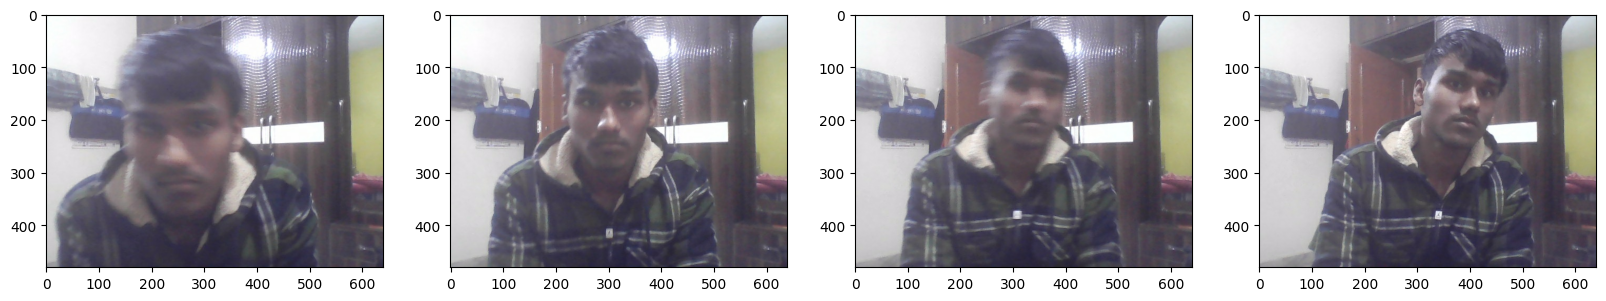

In [17]:
fig, ax = plt.subplots(ncols=4, figsize=(20, 20))
for idx, image in enumerate(plot_images):
    ax[idx].imshow(image) 
plt.show()

data partition into train, test, and validation

In [18]:
from sklearn.model_selection import train_test_split
import shutil

In [21]:
source_folder = "data/images"
train_folder = "data/train/images"
test_folder = "data/test/images"
val_folder = "data/val/images"

os.makedirs(train_folder, exist_ok=True)
os.makedirs(test_folder, exist_ok=True)
os.makedirs(val_folder, exist_ok=True)

all_images = os.listdir(source_folder)

In [22]:
train_images, test_images = train_test_split(all_images, test_size=0.3, random_state=42)
test_images, val_images = train_test_split(test_images, test_size=0.5, random_state=42)

In [23]:
for img in train_images:
    shutil.move(os.path.join(source_folder, img), os.path.join(train_folder, img))

for img in test_images:
    shutil.move(os.path.join(source_folder, img), os.path.join(test_folder, img))

for img in val_images:
    shutil.move(os.path.join(source_folder, img), os.path.join(val_folder, img))

Map the data with respective labels

In [24]:
for folder in ['train', 'test', 'val']:
    for file in os.listdir(os.path.join('data', folder, 'images')):

        filename = file.split('.')[0]+'.json'
        existing_filepath = os.path.join('data', 'labels', filename)
        if os.path.exists(existing_filepath):
            new_filepath = os.path.join('data', folder, 'labels', filename)
            os.replace(existing_filepath, new_filepath)

In [27]:
img = cv2.imread(os.path.join('data', 'train', 'images', '4a21d1ec-a941-11ee-a597-141333dfd063.jpg'))

In [28]:
img.shape

(480, 640, 3)

In [29]:
img

array([[[237, 229, 230],
        [236, 228, 229],
        [233, 228, 227],
        ...,
        [195, 190, 189],
        [194, 189, 188],
        [193, 188, 187]],

       [[236, 228, 229],
        [236, 228, 229],
        [233, 228, 227],
        ...,
        [195, 190, 189],
        [193, 188, 187],
        [192, 187, 186]],

       [[234, 228, 229],
        [233, 227, 228],
        [233, 228, 227],
        ...,
        [196, 189, 186],
        [195, 187, 187],
        [194, 186, 186]],

       ...,

       [[100,  96, 101],
        [ 99,  95, 100],
        [101,  95, 100],
        ...,
        [ 59,  36,  41],
        [ 60,  37,  42],
        [ 60,  37,  42]],

       [[101,  97, 102],
        [100,  96, 101],
        [102,  96, 101],
        ...,
        [ 60,  37,  42],
        [ 62,  36,  42],
        [ 62,  36,  42]],

       [[101,  97, 102],
        [100,  96, 101],
        [101,  95, 100],
        ...,
        [ 60,  37,  42],
        [ 62,  36,  42],
        [ 63,  37,  43]]

Apply augmentation on images and labels using albumentations

In [5]:
import albumentations as alb

In [6]:
augmentor = alb.Compose([alb.RandomCrop(width=450, height=450),
                         alb.HorizontalFlip(p=0.5), 
                         alb.RandomBrightnessContrast(p=0.2), 
                         alb.RandomGamma(p=0.2), 
                         alb.RGBShift(p=0.2), 
                         alb.VerticalFlip(p=0.5)],
                         bbox_params=alb.BboxParams(format='albumentations', 
                                                    label_fields=['class_labels'])
                        )

Load a test image and annotation with openCV and json

In [7]:
img = cv2.imread(os.path.join('data', 'train', 'images', '4a21d1ec-a941-11ee-a597-141333dfd063.jpg'))


In [9]:
with open(os.path.join('data', 'train', 'labels', '4a21d1ec-a941-11ee-a597-141333dfd063.json'), 'r') as f:
    label = json.load(f)

In [10]:
label

{'version': '5.3.1',
 'flags': {},
 'shapes': [{'label': 'face',
   'points': [[320.58479532163744, 2.2807017543859516],
    [589.5906432748538, 347.3099415204678]],
   'group_id': None,
   'description': '',
   'shape_type': 'rectangle',
   'flags': {}}],
 'imagePath': '..\\images\\4a21d1ec-a941-11ee-a597-141333dfd063.jpg',
 'imageData': '/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCAHgAoADASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGR

In [11]:
label['shapes']

[{'label': 'face',
  'points': [[320.58479532163744, 2.2807017543859516],
   [589.5906432748538, 347.3099415204678]],
  'group_id': None,
  'description': '',
  'shape_type': 'rectangle',
  'flags': {}}]

In [12]:
label['shapes'][0]

{'label': 'face',
 'points': [[320.58479532163744, 2.2807017543859516],
  [589.5906432748538, 347.3099415204678]],
 'group_id': None,
 'description': '',
 'shape_type': 'rectangle',
 'flags': {}}

In [13]:
label['shapes'][0]['points']

[[320.58479532163744, 2.2807017543859516],
 [589.5906432748538, 347.3099415204678]]

Extract coordinates and rescale to match image resolution

In [14]:
coords = [0, 0, 0, 0]
coords[0] = label['shapes'][0]['points'][0][0]
coords[1] = label['shapes'][0]['points'][0][1]
coords[2] = label['shapes'][0]['points'][1][0]
coords[3] = label['shapes'][0]['points'][1][1]

In [15]:
coords

[320.58479532163744, 2.2807017543859516, 589.5906432748538, 347.3099415204678]

Transofming our coordinates from raw pascle voc format to albumentations format

In [16]:
coords = list(np.divide(coords, [640, 480, 640, 480]))

In [17]:
coords

[0.5009137426900585,
 0.0047514619883040655,
 0.9212353801169592,
 0.7235623781676412]

Apply augmentation and view results

In [18]:
augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])

In [19]:
type(augmented)

dict

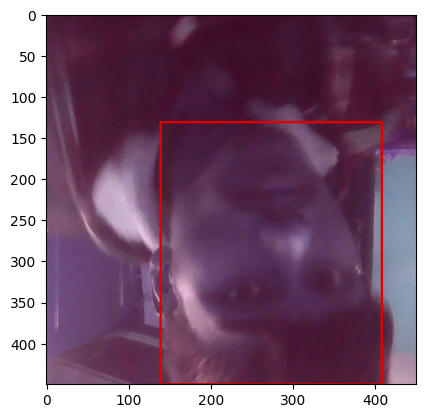

In [21]:
cv2.rectangle(augmented['image'],
              tuple(np.multiply(augmented['bboxes'][0][:2], [450, 450]).astype(int)),
              tuple(np.multiply(augmented['bboxes'][0][2:], [450, 450]).astype(int)),
                (225, 0, 0), 2)

plt.imshow(augmented['image'])

Build and run augmentation pipeline 

In [24]:
for partition in ['train','test','val']: 
    for image in os.listdir(os.path.join('data', partition, 'images')):
        img = cv2.imread(os.path.join('data', partition, 'images', image))

        coords = [0,0,0.00001,0.00001]
        label_path = os.path.join('data', partition, 'labels', f'{image.split(".")[0]}.json')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)

            coords[0] = label['shapes'][0]['points'][0][0]
            coords[1] = label['shapes'][0]['points'][0][1]
            coords[2] = label['shapes'][0]['points'][1][0]
            coords[3] = label['shapes'][0]['points'][1][1]
            coords = list(np.divide(coords, [640,480,640,480]))

        try: 
            for x in range(60):
                augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])
                cv2.imwrite(os.path.join('aug_data', partition, 'images', f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])

                annotation = {}
                annotation['image'] = image

                if os.path.exists(label_path):
                    if len(augmented['bboxes']) == 0: 
                        annotation['bbox'] = [0,0,0,0]
                        annotation['class'] = 0 
                    else: 
                        annotation['bbox'] = augmented['bboxes'][0]
                        annotation['class'] = 1
                else: 
                    annotation['bbox'] = [0,0,0,0]
                    annotation['class'] = 0 


                with open(os.path.join('aug_data', partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(annotation, f)

        except Exception as e:
            print(e)

x_max is less than or equal to x_min for bbox [0.7823464912280702, 0.14485867446393763, 0.370248538011696, 0.6114766081871345, 'face'].


Load augmented images to tensorflow dataset

In [28]:
train_images = tf.data.Dataset.list_files(os.path.join('aug_data', 'train', 'images', '*.jpg'), shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (120, 120)))
train_images = train_images.map(lambda x: x/255)

In [30]:
test_images = tf.data.Dataset.list_files(os.path.join('aug_data', 'test', 'images', '*.jpg'), shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (120, 120)))
test_images = test_images.map(lambda x: x/255)

In [31]:
val_images = tf.data.Dataset.list_files(os.path.join('aug_data', 'val', 'images', '*.jpg'), shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (120, 120)))
val_images = val_images.map(lambda x: x/255)

In [32]:
train_images.as_numpy_iterator().next()

array([[[1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ],
        ...,
        [0.4127451 , 0.3970588 , 0.49509802],
        [0.41029412, 0.39460784, 0.48480392],
        [0.40790442, 0.39123774, 0.47003677]],

       [[1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ],
        ...,
        [0.40300244, 0.3951593 , 0.4814338 ],
        [0.4038603 , 0.39215687, 0.46764705],
        [0.40422794, 0.39246324, 0.4591299 ]],

       [[1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ],
        ...,
        [0.4       , 0.39215687, 0.47843137],
        [0.39950982, 0.3882353 , 0.4697304 ],
        [0.39920342, 0.3874387 , 0.46623775]],

       ...,

       [[0.77052695, 0.7626838 , 0.76954657],
        [0.7255515 , 0.7216299 , 0.74123776],
        [0.6284314 , 0

Prepare labels

Build label loading function

In [33]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding="utf-8") as f:
        label = json.load(f)

    return [label['class']], label['bbox']

Load lables to tensorflow dataset

In [34]:
train_labels = tf.data.Dataset.list_files(os.path.join('aug_data', 'train', 'labels', '*.json'), shuffle=False)
train_labels = train_labels.map(lambda x:tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [35]:
test_labels = tf.data.Dataset.list_files(os.path.join('aug_data', 'test', 'labels', '*.json'), shuffle=False)
test_labels = test_labels.map(lambda x:tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [36]:
val_labels = tf.data.Dataset.list_files(os.path.join('aug_data', 'val', 'labels', '*.json'), shuffle=False)
val_labels = val_labels.map(lambda x:tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [37]:
val_labels.as_numpy_iterator().next()

(array([1], dtype=uint8),
 array([0.0477, 0.1877, 0.6885, 0.9844], dtype=float16))

Combine label and image samples

In [38]:
len(train_images), len(train_labels), len(test_images), len(test_labels), len(val_images), len(val_labels)

(3780, 3780, 780, 780, 780, 780)

Create final datasets (images/labels)

In [44]:
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(4000)
train = train.batch(8)
train = train.prefetch(4)

In [43]:
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(1300)
test = test.batch(8)
test = test.prefetch(4)

In [41]:
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(1000)
val = val.batch(8)
val = val.prefetch(4)

In [47]:
# train.as_numpy_iterator().next()[0].shape
train.as_numpy_iterator().next()[1]

(array([[1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1]], dtype=uint8),
 array([[0.591  , 0.411  , 1.     , 0.9565 ],
        [0.2278 , 0.506  , 0.52   , 0.918  ],
        [0.1192 , 0.29   , 0.522  , 0.8423 ],
        [0.     , 0.2317 , 0.626  , 0.988  ],
        [0.     , 0.2644 , 0.4695 , 0.9517 ],
        [0.431  , 0.2008 , 0.7075 , 0.548  ],
        [0.3442 , 0.08136, 0.7    , 0.5156 ],
        [0.2316 , 0.5986 , 0.5474 , 0.9795 ]], dtype=float16))

View images and annotations

In [48]:
data_samples = train.as_numpy_iterator()

In [54]:
res = data_samples.next()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


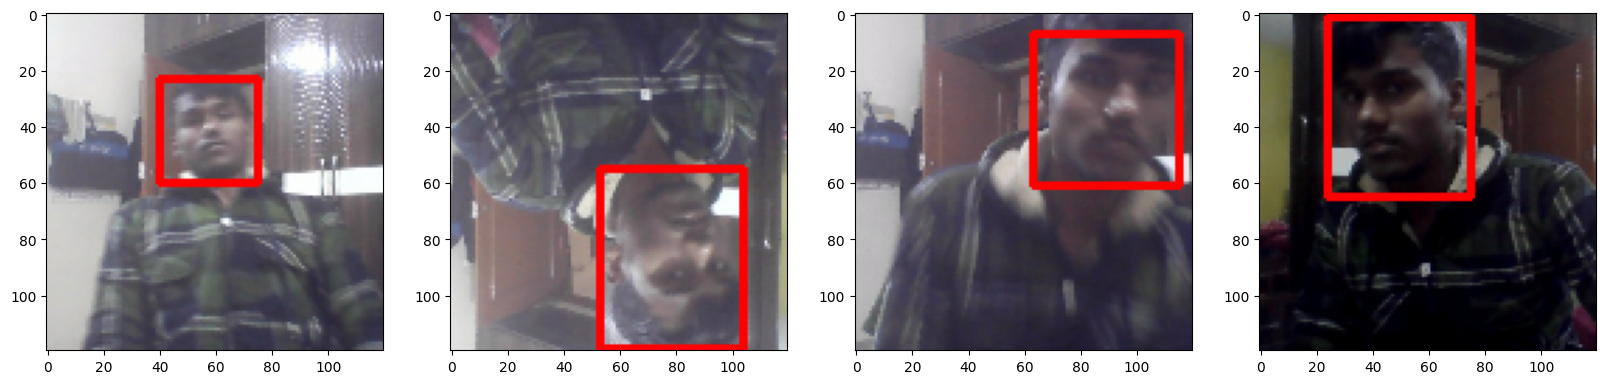

In [55]:
fig, ax = plt.subplots(ncols=4, figsize=(20, 20))
for idx in range(4):
    sample_image = res[0][idx]
    sample_coords = res[1][1][idx]

    cv2.rectangle(sample_image, 
                  tuple(np.multiply(sample_coords[:2], [120, 120]).astype(int)),
                  tuple(np.multiply(sample_coords[2:], [120, 120]).astype(int)),
                   (255, 0, 0), 2)
    ax[idx].imshow(sample_image)

Build Deep learning model using the functional api

In [59]:
from keras.models import Model
from keras.layers import Input, Conv2D, Dense, GlobalMaxPool2D
from keras.applications import VGG16

In [60]:
vgg = VGG16(include_top=False)

In [61]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

Build instance of network

In [ ]:
def build_model():
    input_layer = Input(shape=(120, 120, 3))

    vgg = VGG16(include_top=False)(input_layer)
    # Classification Model
    f1 = GlobalMaxPool2D()(vgg) #to reduce the number of layers from 512 to just max values which are 512 numbers
    class1 = Dense(2048, activation='relu')(f1)
    class2 = Dense(1, activation='sigmoid')(class1)
    # Bounding box model
    f2 = GlobalMaxPool2D()(vgg)
    regress1 = Dense(2048, activation='relu')(f2)
    regress2 = Dense(4, activation='sigmoid')(regress1)

    facetracker = Model(inputs=input_layer, outputs=[class2, regress2])
    return facetracker